In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/Users/assuncaolfi/Projects/site/blog/fantasy-football':
  os.chdir(r'/Users/assuncaolfi/Projects/site/blog/fantasy-football')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/var/folders/6t/m1wx6mz92tn6v72r696k5fg00000gn/T/ipykernel_48585/419478488.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/importlib/_bootstrap.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/importlib/_bootstrap_external.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/zipimport.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/codecs.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/encodings/aliases.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/encodings/__init__.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/encodings/utf_8.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/abc.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/io.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/stat.py": 1609488000.0, "/Users/assuncao

In [2]:
#| label: data-wrangling-players
from pydantic import BaseModel, Field, field_validator
from rich.pretty import pprint
from typing import Callable, Dict, List, Optional
import urllib.request


class Player(BaseModel):
    round: int = Field(alias="rodada_id")
    player: int = Field(alias="atleta_id")
    team: int = Field(alias="clube_id")
    position: int = Field(alias="posicao_id")
    games: int = Field(alias="jogos_num")
    average: float = Field(alias="media_num")
    value: float = Field(alias="preco_num")
    score: float = Field(alias="pontos_num")
    appreciation: float = Field(alias="variacao_num")
    minimum: float | Dict | None = Field(alias="minimo_para_valorizar")

    @field_validator("minimum")
    @classmethod
    def dict_is_zero(cls, v: float | Dict | None):
        if v == {} or v is None:
            v = 0.0
        return v


class Market(BaseModel):
    players: List[Player] = Field(alias="atletas")


base_url = "https://raw.githubusercontent.com/assuncaolfi/tophat/main/2022/"
markets = []
for round in range(1, 39):
    url = base_url + f"{round:02}/atletas/mercado.json"
    data = urllib.request.urlopen(url).read()
    market = Market.model_validate_json(data)
    if round == 1:
        for player in market.players:
            player.round = 0
    markets.extend(market.players)
pprint(markets[0], expand_all=True)

Player(
│   round=0,
│   player=42234,
│   team=264,
│   position=1,
│   games=0,
│   average=0.0,
│   value=10.0,
│   score=0.0,
│   appreciation=0.0,
│   minimum=4.53
)

In [3]:
#| label: data-wrangling-dataframe
import polars as pl

players = (
    pl.DataFrame(markets)
    .with_columns(round=pl.col("round") + 1)
    .sort("round", "player")
)
pprint(players)

shape: (30_063, 10)
┌───────┬────────┬──────┬──────────┬───┬───────┬───────┬──────────────┬─────────┐
│ round ┆ player ┆ team ┆ position ┆ … ┆ value ┆ score ┆ appreciation ┆ minimum │
│ ---   ┆ ---    ┆ ---  ┆ ---      ┆   ┆ ---   ┆ ---   ┆ ---          ┆ ---     │
│ i64   ┆ i64    ┆ i64  ┆ i64      ┆   ┆ f64   ┆ f64   ┆ f64          ┆ f64     │
╞═══════╪════════╪══════╪══════════╪═══╪═══════╪═══════╪══════════════╪═════════╡
│ 1     ┆ 37424  ┆ 1371 ┆ 6        ┆ … ┆ 3.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 1     ┆ 37646  ┆ 314  ┆ 3        ┆ … ┆ 5.0   ┆ 0.0   ┆ 0.0          ┆ 2.3     │
│ 1     ┆ 37656  ┆ 266  ┆ 1        ┆ … ┆ 9.0   ┆ 0.0   ┆ 0.0          ┆ 4.08    │
│ 1     ┆ 37788  ┆ 356  ┆ 1        ┆ … ┆ 4.0   ┆ 0.0   ┆ 0.0          ┆ 1.85    │
│ …     ┆ …      ┆ …    ┆ …        ┆ … ┆ …     ┆ …     ┆ …            ┆ …       │
│ 38    ┆ 121397 ┆ 286  ┆ 2        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 38    ┆ 121398 ┆ 354  ┆ 4        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 38    ┆ 121399 ┆ 354  ┆ 4        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 38    ┆ 121400 ┆ 354  ┆ 5        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
└───────┴────────┴──────┴──────────┴───┴───────┴───────┴──────────────┴─────────┘

In [4]:
#| label: data-wrangling-example
def print_example(markets: pl.DataFrame, columns: List[str]):
    example = players.filter(pl.col("player") == 42234).select(columns)
    pprint(example)


print_example(players, players.columns)

shape: (38, 10)
┌───────┬────────┬──────┬──────────┬───┬───────┬───────┬──────────────┬─────────┐
│ round ┆ player ┆ team ┆ position ┆ … ┆ value ┆ score ┆ appreciation ┆ minimum │
│ ---   ┆ ---    ┆ ---  ┆ ---      ┆   ┆ ---   ┆ ---   ┆ ---          ┆ ---     │
│ i64   ┆ i64    ┆ i64  ┆ i64      ┆   ┆ f64   ┆ f64   ┆ f64          ┆ f64     │
╞═══════╪════════╪══════╪══════════╪═══╪═══════╪═══════╪══════════════╪═════════╡
│ 1     ┆ 42234  ┆ 264  ┆ 1        ┆ … ┆ 10.0  ┆ 0.0   ┆ 0.0          ┆ 4.53    │
│ 2     ┆ 42234  ┆ 264  ┆ 1        ┆ … ┆ 7.93  ┆ 2.0   ┆ -2.07        ┆ 5.52    │
│ 3     ┆ 42234  ┆ 264  ┆ 1        ┆ … ┆ 10.44 ┆ 11.0  ┆ 2.51         ┆ 4.75    │
│ 4     ┆ 42234  ┆ 264  ┆ 1        ┆ … ┆ 10.44 ┆ 0.0   ┆ 0.0          ┆ 5.78    │
│ …     ┆ …      ┆ …    ┆ …        ┆ … ┆ …     ┆ …     ┆ …            ┆ …       │
│ 35    ┆ 42234  ┆ 264  ┆ 1        ┆ … ┆ 11.48 ┆ 0.0   ┆ -0.71        ┆ 3.55    │
│ 36    ┆ 42234  ┆ 264  ┆ 1        ┆ … ┆ 11.51 ┆ 0.0   ┆ 0.03         ┆ 3.63    │
│ 37    ┆ 42234  ┆ 264  ┆ 1        ┆ … ┆ 12.68 ┆ 0.0   ┆ 1.17         ┆ 9.29    │
│ 38    ┆ 42234  ┆ 264  ┆ 1        ┆ … ┆ 11.06 ┆ 0.0   ┆ -1.62        ┆ 1.37    │
└───────┴────────┴──────┴──────────┴───┴───────┴───────┴──────────────┴─────────┘

In [5]:
#| label: data-wrangling-round-participation
players = players.filter(
    pl.col("games") != pl.col("games").shift(1).over("player").fill_null(-1)
)
print_example(markets, ["player", "round", "games"])

shape: (31, 3)
┌────────┬───────┬───────┐
│ player ┆ round ┆ games │
│ ---    ┆ ---   ┆ ---   │
│ i64    ┆ i64   ┆ i64   │
╞════════╪═══════╪═══════╡
│ 42234  ┆ 1     ┆ 0     │
│ 42234  ┆ 2     ┆ 1     │
│ 42234  ┆ 3     ┆ 2     │
│ 42234  ┆ 5     ┆ 3     │
│ …      ┆ …     ┆ …     │
│ 42234  ┆ 35    ┆ 27    │
│ 42234  ┆ 36    ┆ 28    │
│ 42234  ┆ 37    ┆ 29    │
│ 42234  ┆ 38    ┆ 30    │
└────────┴───────┴───────┘

In [6]:
#| label: data-wrangling-missing-scores
# TODO make this better
players = players.with_columns(
    average=pl.col("average")
    .shift(-1)
    .over("player")
    .fill_null(pl.col("average"))
).with_columns(
    score=2 * pl.col("average")
    - pl.col("average").shift(1).over("player").fill_null(pl.col("average")),
)
print_example(players, ["player", "round", "score", "average"])

shape: (31, 4)
┌────────┬───────┬───────┬─────────┐
│ player ┆ round ┆ score ┆ average │
│ ---    ┆ ---   ┆ ---   ┆ ---     │
│ i64    ┆ i64   ┆ f64   ┆ f64     │
╞════════╪═══════╪═══════╪═════════╡
│ 42234  ┆ 1     ┆ 2.0   ┆ 2.0     │
│ 42234  ┆ 2     ┆ 11.0  ┆ 6.5     │
│ 42234  ┆ 3     ┆ 9.5   ┆ 8.0     │
│ 42234  ┆ 5     ┆ 8.6   ┆ 8.3     │
│ …      ┆ …     ┆ …     ┆ …       │
│ 42234  ┆ 35    ┆ 4.73  ┆ 4.82    │
│ 42234  ┆ 36    ┆ 5.1   ┆ 4.96    │
│ 42234  ┆ 37    ┆ 4.62  ┆ 4.79    │
│ 42234  ┆ 38    ┆ 4.79  ┆ 4.79    │
└────────┴───────┴───────┴─────────┘

In [7]:
#| label: data-wrangling-fixtures
class Fixture(BaseModel):
    round: int = Field(default=0)
    home: int = Field(alias="clube_casa_id")
    away: int = Field(alias="clube_visitante_id")


class Round(BaseModel):
    round: int = Field(alias="rodada")
    fixtures: List[Fixture] = Field(alias="partidas")


fixtures = []
for round in range(1, 39):
    url = base_url + f"{round:02}/partidas.json"
    data = urllib.request.urlopen(url).read()
    round = Round.model_validate_json(data)
    for fixture in round.fixtures:
        fixture.round = round.round
    fixtures.extend(round.fixtures)
pprint(fixtures[0])

Fixture(round=1, home=282, away=285)

In [8]:
#| label: data-wrangling-fixtures-long
fixtures = (
    pl.DataFrame(fixtures)
    .rename({"home": "team", "away": "opponent"})
    .with_columns(home=pl.lit(1))
)
mirrored = fixtures.rename(
    {"team": "opponent", "opponent": "team"}
).with_columns(home=pl.lit(0))
fixtures = pl.concat([fixtures, mirrored], how="diagonal")
pprint(fixtures)

shape: (760, 4)
┌───────┬──────┬──────────┬──────┐
│ round ┆ team ┆ opponent ┆ home │
│ ---   ┆ ---  ┆ ---      ┆ ---  │
│ i64   ┆ i64  ┆ i64      ┆ i32  │
╞═══════╪══════╪══════════╪══════╡
│ 1     ┆ 282  ┆ 285      ┆ 1    │
│ 1     ┆ 266  ┆ 277      ┆ 1    │
│ 1     ┆ 276  ┆ 293      ┆ 1    │
│ 1     ┆ 373  ┆ 262      ┆ 1    │
│ …     ┆ …    ┆ …        ┆ …    │
│ 38    ┆ 286  ┆ 354      ┆ 0    │
│ 38    ┆ 276  ┆ 290      ┆ 0    │
│ 38    ┆ 294  ┆ 1371     ┆ 0    │
│ 38    ┆ 263  ┆ 293      ┆ 0    │
└───────┴──────┴──────────┴──────┘

In [9]:
#| label: data-wrangling-fixtures-join
players = players.join(fixtures, on=["round", "team"], how="inner")
print_example(players, ["player", "round", "team", "opponent", "home"])

shape: (31, 5)
┌────────┬───────┬──────┬──────────┬──────┐
│ player ┆ round ┆ team ┆ opponent ┆ home │
│ ---    ┆ ---   ┆ ---  ┆ ---      ┆ ---  │
│ i64    ┆ i64   ┆ i64  ┆ i64      ┆ i32  │
╞════════╪═══════╪══════╪══════════╪══════╡
│ 42234  ┆ 1     ┆ 264  ┆ 263      ┆ 0    │
│ 42234  ┆ 2     ┆ 264  ┆ 314      ┆ 1    │
│ 42234  ┆ 3     ┆ 264  ┆ 275      ┆ 0    │
│ 42234  ┆ 5     ┆ 264  ┆ 280      ┆ 0    │
│ …      ┆ …     ┆ …    ┆ …        ┆ …    │
│ 42234  ┆ 35    ┆ 264  ┆ 262      ┆ 0    │
│ 42234  ┆ 36    ┆ 264  ┆ 354      ┆ 1    │
│ 42234  ┆ 37    ┆ 264  ┆ 294      ┆ 0    │
│ 42234  ┆ 38    ┆ 264  ┆ 282      ┆ 1    │
└────────┴───────┴──────┴──────────┴──────┘

In [10]:
#| label: data-wrangling-lookahead-variables
players = players.with_columns(
    average=pl.col("average").shift(1).over("player").fill_null(0.0),
    appreciation=pl.col("appreciation").shift(-1).over("player").fill_null(0.0),
)
print_example(
    players, ["player", "round", "average", "value", "score", "appreciation"]
)

shape: (31, 6)
┌────────┬───────┬─────────┬───────┬───────┬──────────────┐
│ player ┆ round ┆ average ┆ value ┆ score ┆ appreciation │
│ ---    ┆ ---   ┆ ---     ┆ ---   ┆ ---   ┆ ---          │
│ i64    ┆ i64   ┆ f64     ┆ f64   ┆ f64   ┆ f64          │
╞════════╪═══════╪═════════╪═══════╪═══════╪══════════════╡
│ 42234  ┆ 1     ┆ 0.0     ┆ 10.0  ┆ 2.0   ┆ -2.07        │
│ 42234  ┆ 2     ┆ 2.0     ┆ 7.93  ┆ 11.0  ┆ 2.51         │
│ 42234  ┆ 3     ┆ 6.5     ┆ 10.44 ┆ 9.5   ┆ 1.25         │
│ 42234  ┆ 5     ┆ 8.0     ┆ 11.69 ┆ 8.6   ┆ 0.73         │
│ …      ┆ …     ┆ …       ┆ …     ┆ …     ┆ …            │
│ 42234  ┆ 35    ┆ 4.91    ┆ 11.48 ┆ 4.73  ┆ 0.03         │
│ 42234  ┆ 36    ┆ 4.82    ┆ 11.51 ┆ 5.1   ┆ 1.17         │
│ 42234  ┆ 37    ┆ 4.96    ┆ 12.68 ┆ 4.62  ┆ -1.62        │
│ 42234  ┆ 38    ┆ 4.79    ┆ 11.06 ┆ 4.79  ┆ 0.0          │
└────────┴───────┴─────────┴───────┴───────┴──────────────┘

In [11]:
#| label: team-picking-formation
import numpy as np
import pulp


class Formation(BaseModel):
    goalkeeper: int = Field(alias="gol")
    defender: int = Field(alias="zag")
    winger: int = Field(alias="lat")
    midfielder: int = Field(alias="mei")
    forward: int = Field(alias="ata")
    coach: int = Field(alias="tec")

In [12]:
#| echo: true
#| label: team-picking-problem
class Problem(BaseModel):
    scores: List[float]
    values: List[float]
    budget: float
    positions: List[List[int]]
    formations: List[Formation]

    def solve(self) -> List[pulp.LpSolution]:
        formations = [list(f.model_dump().values()) for f in self.formations]
        problems = [self.construct(f) for f in formations]
        [p.solve(pulp.COIN(msg=False)) for p in problems]
        objectives = [p.objective.value() for p in problems]
        best = np.argmax(np.array(objectives))
        solution = problems[best]
        variables = [v.value() for v in solution.variables()]
        picks = np.array(variables)
        return picks

    def construct(self, formation: List[int]) -> pulp.LpProblem:
        n = len(self.scores)
        m = len(formation)
        problem = pulp.LpProblem("team_picking", pulp.LpMaximize)
        indexes = ["pick_" + str(i).zfill(len(str(n))) for i in range(n)]
        picks = [pulp.LpVariable(i, cat=pulp.const.LpBinary) for i in indexes]
        problem += pulp.lpDot(picks, self.scores)
        problem += pulp.lpDot(picks, self.values) <= self.budget
        for i in range(m):
            problem += pulp.lpDot(picks, self.positions[i]) == formation[i]
        return problem

In [13]:
#| label: team-picking-formations
from pydantic import RootModel


class MetaFormation(BaseModel):
    id: int = Field(alias="esquema_id")
    name: str = Field(alias="nome")
    formation: Formation = Field(alias="posicoes")


class MetaFormations(RootModel):
    root: List[MetaFormation]


url = base_url + "38/esquemas.json"
data = urllib.request.urlopen(url).read()
meta_formations = MetaFormations.model_validate_json(data).root
formations = [m.formation for m in meta_formations]
pprint(formations)

[
│   Formation(goalkeeper=1, defender=3, winger=0, midfielder=4, forward=3, coach=1),
│   Formation(goalkeeper=1, defender=3, winger=0, midfielder=5, forward=2, coach=1),
│   Formation(goalkeeper=1, defender=2, winger=2, midfielder=3, forward=3, coach=1),
│   Formation(goalkeeper=1, defender=2, winger=2, midfielder=4, forward=2, coach=1),
│   Formation(goalkeeper=1, defender=2, winger=2, midfielder=5, forward=1, coach=1),
│   Formation(goalkeeper=1, defender=3, winger=2, midfielder=3, forward=2, coach=1),
│   Formation(goalkeeper=1, defender=3, winger=2, midfielder=4, forward=1, coach=1)
]

In [14]:
#| label: team-picking-backtest-import
from typing import Callable

In [15]:
#| echo: true
#| label: team-picking-backtest
def backtest(
    players: pl.DataFrame, predict: Callable, initial_budget: float = 100.0
) -> pl.DataFrame:
    rounds = players.get_column("round").max()
    budget = [None] * rounds
    teams = [None] * rounds
    budget[0] = initial_budget
    for round in range(rounds):
        if round > 0:
            budget[round] = budget[round - 1] + appreciation
        data = players.filter(pl.col("round") < round + 1)
        candidates = players.filter(pl.col("round") == round + 1)
        candidates = predict(data, candidates)
        problem = Problem(
            scores=candidates.get_column("prediction"),
            values=candidates.get_column("value"),
            positions=candidates.get_column("position").to_dummies(),
            budget=budget[round],
            formations=formations,
        )
        picks = problem.solve()
        team = candidates.filter(picks == 1)
        teams[round] = team
        appreciation = team.get_column("appreciation").sum()
    teams = pl.concat(teams)
    return teams

In [16]:
#| label: team-picking-backtest-first-team
def predict_score(data: pl.DataFrame, candidates: pl.DataFrame) -> pl.DataFrame:
    prediction = candidates.get_column("score")
    candidates = candidates.with_columns(prediction=prediction)
    return candidates


teams = backtest(players, predict_score)
pprint(teams.filter(pl.col("round") == 1).sort("position"))

shape: (12, 13)
┌───────┬────────┬──────┬──────────┬───┬─────────┬──────────┬──────┬────────────┐
│ round ┆ player ┆ team ┆ position ┆ … ┆ minimum ┆ opponent ┆ home ┆ prediction │
│ ---   ┆ ---    ┆ ---  ┆ ---      ┆   ┆ ---     ┆ ---      ┆ ---  ┆ ---        │
│ i64   ┆ i64    ┆ i64  ┆ i64      ┆   ┆ f64     ┆ i64      ┆ i32  ┆ f64        │
╞═══════╪════════╪══════╪══════════╪═══╪═════════╪══════════╪══════╪════════════╡
│ 1     ┆ 71571  ┆ 356  ┆ 1        ┆ … ┆ 3.19    ┆ 1371     ┆ 1    ┆ 11.0       │
│ 1     ┆ 42145  ┆ 294  ┆ 2        ┆ … ┆ 2.75    ┆ 290      ┆ 1    ┆ 15.8       │
│ 1     ┆ 105584 ┆ 264  ┆ 2        ┆ … ┆ 2.75    ┆ 263      ┆ 0    ┆ 10.5       │
│ 1     ┆ 107110 ┆ 280  ┆ 3        ┆ … ┆ 2.3     ┆ 286      ┆ 0    ┆ 14.9       │
│ …     ┆ …      ┆ …    ┆ …        ┆ … ┆ …       ┆ …        ┆ …    ┆ …          │
│ 1     ┆ 39148  ┆ 282  ┆ 5        ┆ … ┆ 7.2     ┆ 285      ┆ 1    ┆ 18.9       │
│ 1     ┆ 89840  ┆ 276  ┆ 5        ┆ … ┆ 5.42    ┆ 293      ┆ 1    ┆ 27.1       │
│ 1     ┆ 104530 ┆ 294  ┆ 5        ┆ … ┆ 2.3     ┆ 290      ┆ 1    ┆ 11.0       │
│ 1     ┆ 97341  ┆ 276  ┆ 6        ┆ … ┆ 0.0     ┆ 293      ┆ 1    ┆ 9.52       │
└───────┴────────┴──────┴──────────┴───┴─────────┴──────────┴──────┴────────────┘

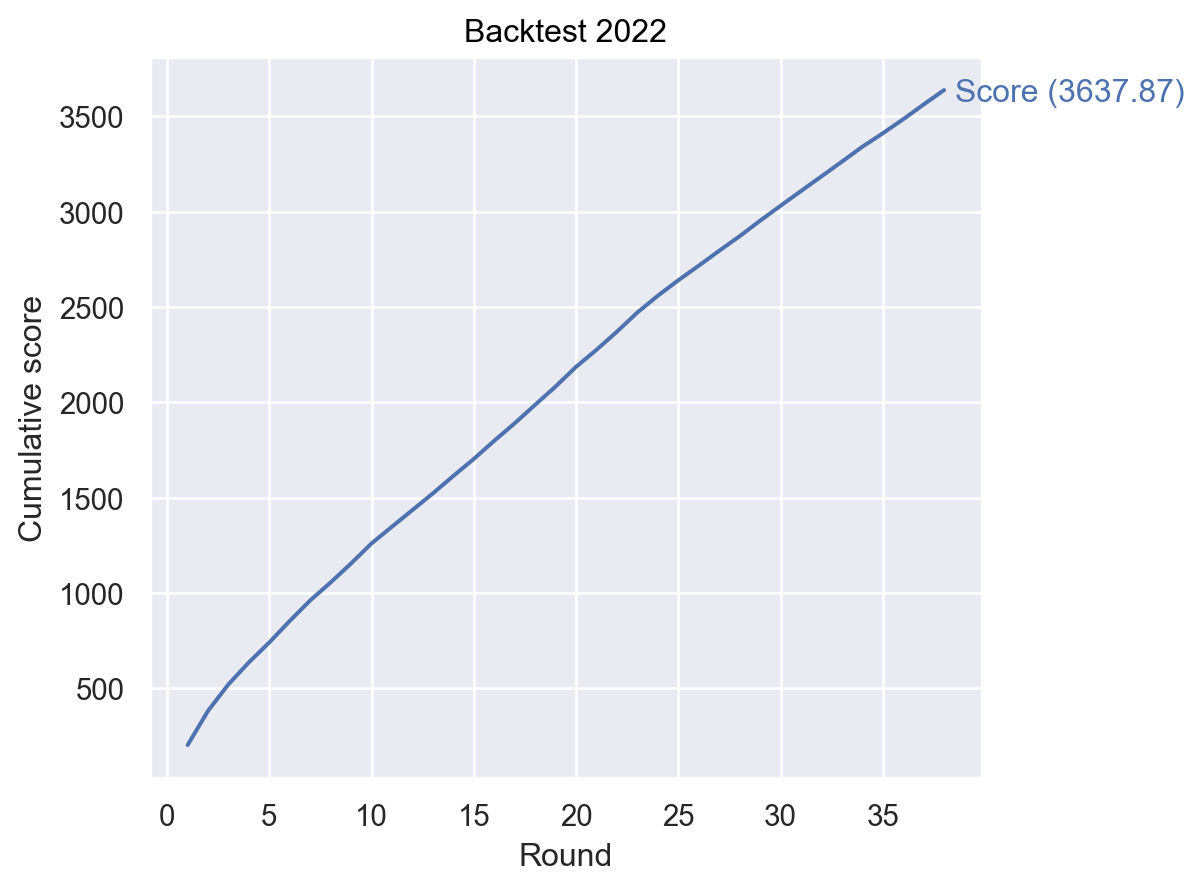

In [17]:
#| label: team-picking-backtest-score
import seaborn.objects as so


def summarize(teams: pl.DataFrame, model: str) -> pl.DataFrame:
    captains = (
        teams.filter(pl.col("position") != 6)
        .filter(
            pl.col("prediction") == pl.col("prediction").over("round").max()
        )
        .with_columns(captain=2.0)
        .select("round", "player", "captain")
    )  # TODO review
    campaign = (
        teams.join(captains, on=["round", "player"], how="left")
        .with_columns(score=pl.col("score") * pl.col("captain").fill_null(1.0))
        .group_by("round")
        .agg(score=pl.col("score").sum())
        .with_columns(score=pl.col("score").cumsum())
    )
    score = campaign.get_column("score").tail(1).round(2).item()
    label = f"{model} ({score})"
    campaign = campaign.with_columns(label=pl.lit(label))
    return campaign


def add_line(
    fig: so.Plot,
    campaign: pl.DataFrame,
    linestyle: str = "solid",
    halign: str = "left",
) -> so.Plot:
    text = campaign.tail(1)
    fig = fig.add(
        so.Line(linestyle=linestyle),
        data=campaign,
        legend=False,
    ).add(
        so.Text({"clip_on": False}, halign=halign, offset=4),
        data=text,
    )
    return fig


season = summarize(teams, "Score")
fig = so.Plot(season, x="round", y="score", color="label", text="label").label(
    title="Backtest 2022", x="Round", y="Cumulative score"
)
fig = add_line(fig, season)
fig

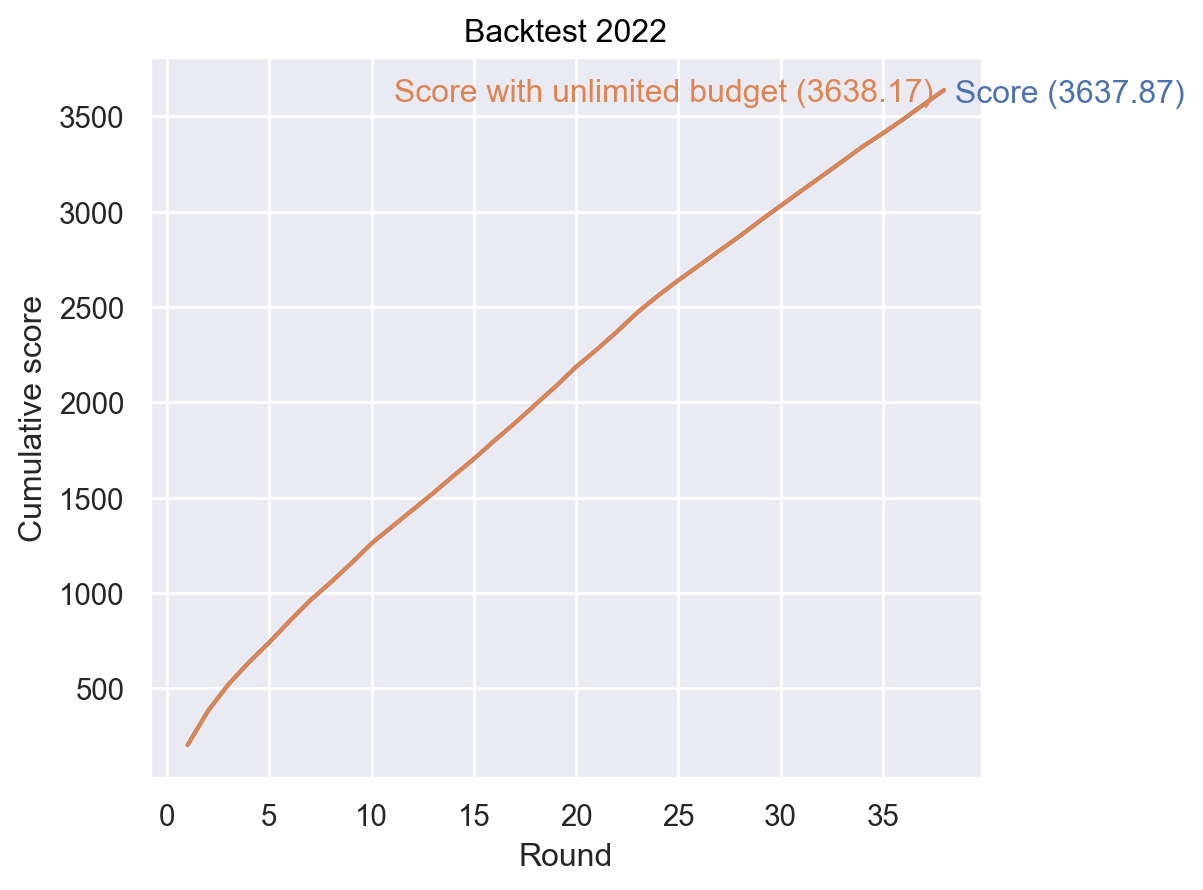

In [18]:
#| label: team-picking-backtest-score-unlimited-budget
# TODO use kwargs
def add_backtest(
    fig: so.Plot, teams: pl.DataFrame, model: str, halign: str = "left"
) -> so.Plot:
    campaign = summarize(teams, model)
    fig = add_line(fig, campaign, halign=halign)
    return fig


teams = backtest(players, predict_score, initial_budget=1000.0)
add_backtest(fig, teams, "Score with unlimited budget", halign="right")

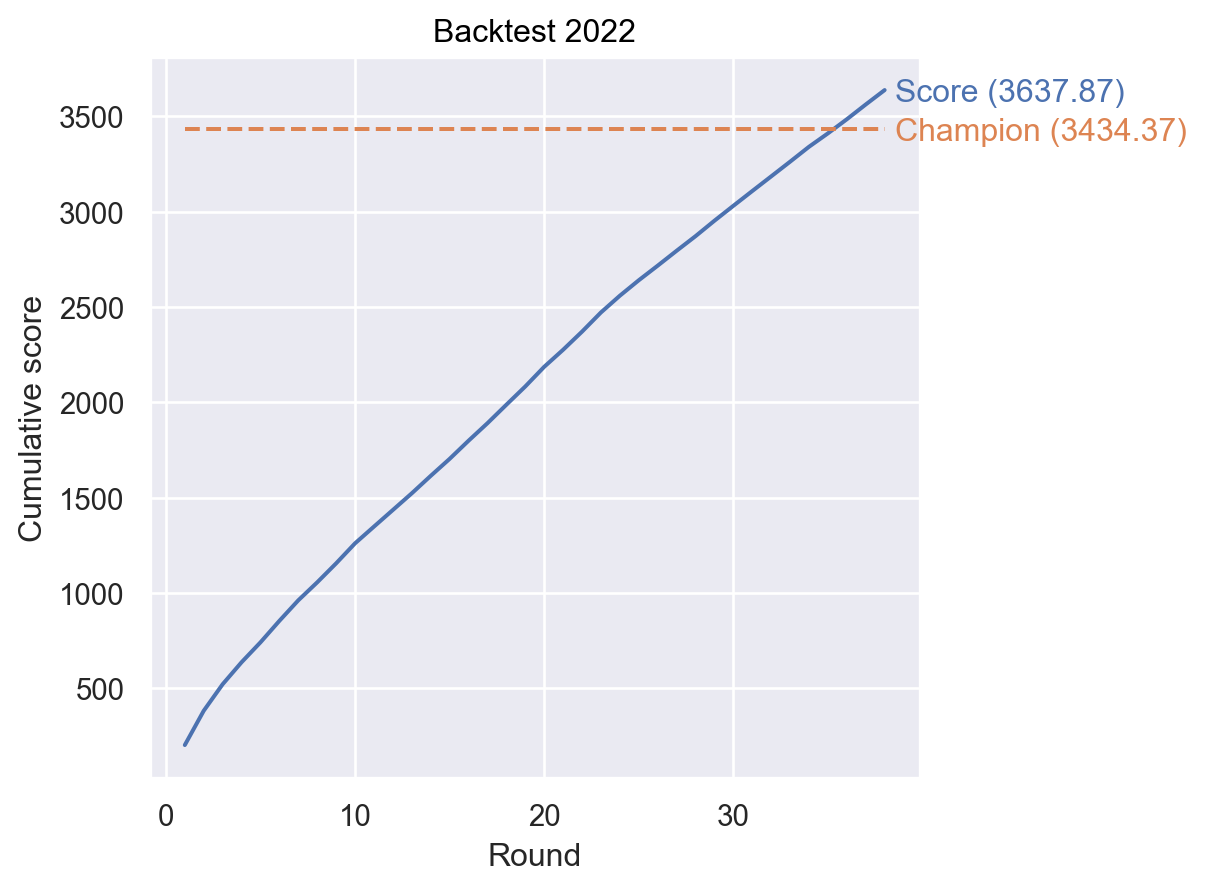

In [19]:
#| label: team-picking-backtest-champion
champion = players.unique("round").with_columns(
    score=pl.lit(3434.37), label=pl.lit("Champion (3434.37)")
)
fig = add_line(fig, champion, linestyle="dashed")
fig

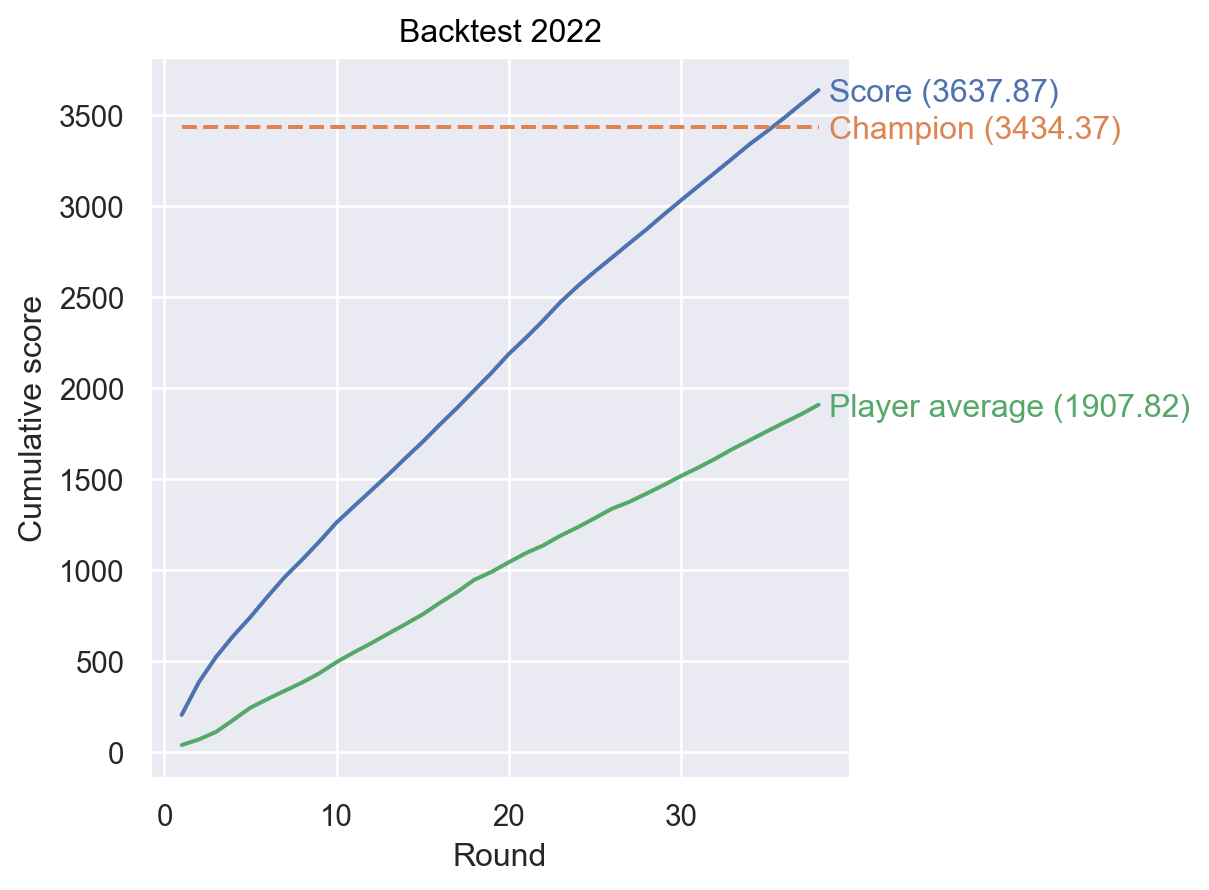

In [20]:
#| label: score-prediction-player-average
def predict_average(data: pl.DataFrame, candidates: pl.DataFrame):
    candidates = candidates.with_columns(
        prediction=pl.when(pl.col("round") == 1)
        .then(pl.col("value"))
        .otherwise(pl.col("average"))
    )
    return candidates


teams = backtest(players, predict_average)
add_backtest(fig, teams, "Player average")

In [21]:
#| label: score-prediction-player-random-effects
import arviz as az
import bambi as bmb
import logging
import pymc as pm
from functools import partial

logger = logging.getLogger("pymc")
logger.propagate = False


def predict_model(
    data: pl.DataFrame,
    candidates: pl.DataFrame,
    formula: str,
    categorical: List[str],
) -> pl.DataFrame:
    if data.height == 0:
        predictions = candidates.get_column("value")
    else:
        model = bmb.Model(
            formula, data=data.to_pandas(), categorical=categorical
        )
        inference = model.fit(progressbar=False, random_seed=37)
        predictions = model.predict(
            inference,
            kind="mean",
            data=candidates.to_pandas(),
            sample_new_groups=True,
            inplace=False,
        )
        summary = az.summary(predictions, var_names=["score_mean"])
        predictions = summary["mean"].values
    candidates = candidates.with_columns(prediction=pl.lit(predictions))
    return candidates


# predict_random_effects = partial(
#     predict_model, formula="score ~ (1 | player)", categorical=["player"]
# )
# teams = backtest(players, predict_random_effects)
# fig = add_backtest(fig, teams, "Random effects")
# fig


def predict_model(data: pl.DataFrame, candidates: pl.DataFrame):
    if data.height == 0:
        predictions = candidates.get_column("value")
        candidates = candidates.with_columns(prediction=pl.lit(predictions))
        return candidates
    x = data.with_columns(intercept=pl.lit(1.0)).select("intercept").to_numpy()
    z = data.get_column("player").to_dummies().to_numpy()
    y = data.select("score").to_numpy()
    with pm.Model() as model:
        beta = pm.Flat("beta", shape=(x.shape[1], 1))
        sigma_b = pm.HalfFlat("sigma_b")
        b = pm.Normal("b", 0.0, sigma_b, shape=(z.shape[1], 1))
        score = pm.Deterministic("score", pm.math.dot(z, b))
        sigma = pm.HalfFlat("sigma")
        pm.Normal(
            "y",
            mu=score,
            sigma=sigma,
            observed=y,
        )
        maps = pm.find_MAP()
    predictions = maps["score"]
    data = data.with_columns(prediction=pl.lit(predictions))
    return maps


preds = predict_model(
    players.filter(pl.col("round") < 10), players.filter(pl.col("round") == 10)
)
pprint(preds)
# teams = backtest(players, predict_model)
# fig = add_backtest(fig, teams, "Random effects")
# fig

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/pytensor/gradient.py:592: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: beta
  handle_disconnected(elem)
/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/pytensor/gradient.py:622: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: <DisconnectedType>
  handle_disconnected(_rval[i])


{
│   'beta': array([[0.]]),
│   'sigma_b_log__': array(-19.41311239),
│   'b': array([[-5.20393119e-11],
│      [ 5.81599896e-09],
│      [-3.35950963e-09],
│      [ 6.75637621e-09],
│      [ 3.73245042e-09],
│      [-4.86526934e-09],
│      [-5.65709460e-10],
│      [-1.31414679e-09],
│      [ 5.47343081e-09],
│      [ 2.26283784e-10],
│      [-5.32247754e-09],
│      [ 4.66774935e-10],
│      [ 6.17358259e-10],
│      [ 9.64337881e-10],
│      [ 6.49439428e-09],
│      [ 1.57769333e-09],
│      [ 1.76493093e-09],
│      [-1.45796442e-09],
│      [ 4.27854883e-09],
│      [ 6.87212731e-09],
│      [-2.53765534e-09],
│      [ 0.00000000e+00],
│      [-1.44083845e-09],
│      [ 5.97594583e-09],
│      [ 1.80476968e-09],
│      [-8.71192568e-09],
│      [-2.37735560e-09],
│      [-7.48065513e-10],
│      [-1.51889742e-09],
│      [-9.30417090e-10],
│      [-1.13141892e-10],
│      [ 5.40736991e-10],
│      [-2.00026105e-09],
│      [ 0.00000000e+00],
│      [-6.02366680e-09],
│      [ 2.98253749e-09],
│      [ 0.00000000e+00],
│      [ 8.48564190e-10],
│      [-8.93820946e-09],
│      [ 4.37756311e-10],
│      [ 8.91739707e-10],
│      [ 0.00000000e+00],
│      [-8.10187039e-09],
│      [-4.70420001e-09],
│      [-1.78704540e-09],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [ 9.56198543e-10],
│      [ 3.93874524e-10],
│      [ 5.65709460e-11],
│      [ 0.00000000e+00],
│      [-6.78851352e-10],
│      [ 3.15311949e-10],
│      [ 0.00000000e+00],
│      [ 4.74063210e-09],
│      [-2.74381448e-09],
│      [-1.23471652e-09],
│      [ 2.32130722e-09],
│      [-2.30449335e-09],
│      [-7.79578601e-10],
│      [ 2.74969004e-10],
│      [ 1.08129596e-08],
│      [ 0.00000000e+00],
│      [-1.33752757e-09],
│      [-4.18625000e-09],
│      [ 6.78044550e-10],
│      [-1.08647610e-09],
│      [ 0.00000000e+00],
│      [-2.81662775e-09],
│      [ 0.00000000e+00],
│      [-7.37704094e-09],
│      [-8.23144345e-10],
│      [-3.50739865e-09],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [-2.74381448e-09],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [-3.26871928e-09],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [-1.92067014e-09],
│      [ 4.42012987e-09],
│      [ 5.98066436e-10],
│      [-4.89192272e-09],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [-2.20942251e-09],
│      [ 0.00000000e+00],
│      [-1.93954690e-09],
│      [ 1.04985813e-08],
│      [-2.31940878e-09],
│      [ 1.19684379e-08],
│      [ 0.00000000e+00],
│      [ 1.03183039e-08],
│      [ 0.00000000e+00],
│      [-7.85383972e-10],
│      [-6.01389206e-10],
│      [-3.83552672e-09],
│      [-1.92067014e-09],
│      [-1.62175644e-09],
│      [ 3.72622708e-09],
│      [ 0.00000000e+00],
│      [-5.20393119e-11],
│      [ 3.09455769e-09],
│      [-1.43252002e-09],
│      [ 1.05776365e-09],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [ 6.36492484e-09],
│      [-1.44778665e-09],
│      [ 0.00000000e+00],
│      [ 1.00435601e-08],
│      [-8.03356878e-10],
│      [ 1.06018355e-10],
│      [-5.09138514e-10],
│      [ 0.00000000e+00],
│      [-1.50909797e-09],
│      [ 2.30485605e-09],
│      [ 3.28498156e-10],
│      [-1.75369933e-09],
│      [-3.67611797e-09],
│      [ 5.21627176e-10],
│      [-4.09390134e-09],
│      [ 2.57802015e-09],
│      [ 0.00000000e+00],
│      [-1.10304041e-09],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [-7.87928418e-10],
│      [-3.66877149e-09],
│      [ 2.74381448e-10],
│      [ 0.00000000e+00],
│      [-5.31766892e-09],
│      [ 0.00000000e+00],
│      [ 0.00000000e+00],
│      [ 5.74002230e-10],
│      [ 3.29650380e-10],
│      [-2.05786086e-09],
│      [-2.74381448e-09],
│      [ 0.00000000e+00],
│      [-1.69146532e-09],
│      [ 0.00000000e+00],
│      [ 3.96115830e-09],
│      [-1.47451724e-09],
│      [-1.59920357e-09],
│      [-4.80167534e-09],
│      [ 7.27588522e